In [1]:
#패키지 업로드
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import plot_model
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.decomposition import PCA
import tensorflow as tf 

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.
C:\Users\Family\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Family\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Family\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Family\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
# 고객의 선호도 정리 파일 로드
data = pd.read_csv('C:\\Users\\Family\\Desktop\\상현\\파이썬\\텍스트\\추천시스템유사도함수\\grade_item.csv', sep=",")

In [3]:
# 출력
data.head()

,CUSTOMER,FASH-WO,FASH-MA,FASH-WAT,FASH-JUR,FASH-UND,FASH-MBAG,FASH-WBAG,FASH-MIS,FASH-WWAL,...,DIGI-CELL,DIGI-NOTE,DIGI-SOUND,DIGI-GAME,DIGI-LIFE,DIGI-PRT,DIGI-PC,DIGI-DISP,DIGI-HARD,PERFORM
0,CUS-1,9,6,7,2,5,3,8,5,7,...,5,2,10,4,6,4,3,10,6,0
1,CUS-2,8,0,6,6,1,9,6,1,2,...,6,1,3,4,3,4,0,3,7,4
2,CUS-3,9,5,8,3,9,6,0,10,4,...,4,6,9,10,1,1,6,1,2,4
3,CUS-4,3,8,3,0,2,8,6,9,7,...,2,1,3,7,6,0,8,1,4,6
4,CUS-5,0,9,1,8,5,1,6,6,2,...,2,1,5,5,0,6,2,7,7,4


In [4]:
# CUSTOMER 부분은 평점과 관련 없으므로 제거
data.index=data.iloc[:,0]
data = data.drop("CUSTOMER", 1)

In [5]:
data.head()

,FASH-WO,FASH-MA,FASH-WAT,FASH-JUR,FASH-UND,FASH-MBAG,FASH-WBAG,FASH-MIS,FASH-WWAL,FASH-MWAL,...,DIGI-CELL,DIGI-NOTE,DIGI-SOUND,DIGI-GAME,DIGI-LIFE,DIGI-PRT,DIGI-PC,DIGI-DISP,DIGI-HARD,PERFORM
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
CUS-1,9,6,7,2,5,3,8,5,7,5,...,5,2,10,4,6,4,3,10,6,0
CUS-2,8,0,6,6,1,9,6,1,2,9,...,6,1,3,4,3,4,0,3,7,4
CUS-3,9,5,8,3,9,6,0,10,4,5,...,4,6,9,10,1,1,6,1,2,4
CUS-4,3,8,3,0,2,8,6,9,7,1,...,2,1,3,7,6,0,8,1,4,6
CUS-5,0,9,1,8,5,1,6,6,2,1,...,2,1,5,5,0,6,2,7,7,4


In [6]:
print(len(data.columns))
print(data.PERFORM.value_counts())

# 2차원의 데이터 (70000명의 회원수, 93개의 상품)
data.shape

93
5     7648
2     7467
8     7460
9     6852
6     6806
1     6798
4     6788
3     6748
7     6698
10    3770
0     2965
Name: PERFORM, dtype: int64


(70000, 93)

In [7]:
factor_sum=0

# 93개의 항목들의 점수들의 갯수를 더하고 출력(0~10점 -> 11개 * 93 = 1023)
for i in range(data.shape[1]):
    #print(len(data.iloc[:,i].value_counts()))
    factor_sum +=len(data.iloc[:,i].value_counts())
    
print(factor_sum)

1023


In [8]:
colnames=data.columns
from random import shuffle

REP=1 # number of shuffled sentences
sentences = []

# 7만명의 각자 상품명에 따른 점수를 한 문장처럼 이어주기
# 순서를 학습하지 않기 위해 셔플
for i in range(data.shape[0]):
    if i%10000==0:
        print(i)
    for j in range(REP):
        sentence=list(colnames + data.iloc[i,:].map(str))
        np.random.shuffle(sentence)
        sentences.append(sentence)
        


0
10000
20000
30000
40000
50000
60000


In [9]:
print(len(sentences))

70000


In [10]:
# skipgram을 이용하여 50차원의 벡터로 변환 (출현빈도 1번 미만 단어는 제외하고 앞뒤로 5단어를 봄)
from gensim.models import Word2Vec
embed_model = Word2Vec(sentences, sg=1, size=50, window=5, min_count=1) 
embed_model.save("word2vec_ITEM_GRADE")
print(embed_model.wv.vocab)

{'LIFE-KIT5': <gensim.models.keyedvectors.Vocab object at 0x000001D0CB8D2248>, 'BEAT-MAST6': <gensim.models.keyedvectors.Vocab object at 0x000001D0CD808FC8>, 'FASH-WWAL7': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17A88>, 'ART2': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17A48>, 'FASH-MBAG3': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17B08>, 'FOOD-KIMCH5': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17B88>, 'DIGI-GAME4': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17BC8>, 'TRV-TIKE0': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17C08>, 'LESR-HEAT2': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17AC8>, 'DIGI-PC3': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17B48>, 'FISH9': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17C48>, 'LIFE-MASS8': <gensim.models.keyedvectors.Vocab object at 0x000001D0F1B17C88>, 'FURN-REM10': <gensim.models.keyedvectors.Vocab object at 0x00000

In [29]:
print(len(embed_model.wv.vocab)) 
X = embed_model[embed_model.wv.vocab]
print(X.shape)

1023
(1023, 50)


C:\Users\Family\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [12]:
# 단어에 각 인덱스를 부여
index2word = {i: w for i, w in enumerate(embed_model.wv.index2word)} 
word2index = {w: i for i, w in index2word.items() }
print(len(word2index))
print(len(embed_model.wv.index2word))
print(word2index)
print(index2word.values())

1023
1023
{'LESR-ELEC2': 0, 'BOOK8': 1, 'FASH-MIS8': 2, 'FURN-DESK2': 3, 'FOOD-KIMCH8': 4, 'LESR-SWIM8': 5, 'FASH-JUR8': 6, 'BEAT-MAST2': 7, 'FOOD-DIET8': 8, 'FOOD-AGR8': 9, 'FURN-CHR2': 10, 'LIFE-BATH5': 11, 'BEAT-BODY2': 12, 'FURN-CHID2': 13, 'LESR-CAP8': 14, 'FLOWER8': 15, 'DIGI-AIR5': 16, 'LESR-FISH8': 17, 'FOOD-SIDI8': 18, 'PERFORM5': 19, 'DIGI-HARD8': 20, 'LESR-BOX2': 21, 'LESR-GOLF5': 22, 'LESR-MTN2': 23, 'FURN-KIT5': 24, 'FOOD-MAR8': 25, 'FOOD-DIET2': 26, 'FOOD-PROC8': 27, 'TRV-AIR2': 28, 'BEAT-PERF8': 29, 'BEAT-MAKE8': 30, 'DIGI-AIR8': 31, 'FASH-MIS5': 32, 'FURN-REM5': 33, 'BEAT-LOTT2': 34, 'DIGI-SOUND2': 35, 'CLOTH-MWAL5': 36, 'LESR-HEAT8': 37, 'BEAT-LOTT8': 38, 'FURN-INN8': 39, 'LESR-MTN8': 40, 'CLOTH-WSHO5': 41, 'FASH-MBAG8': 42, 'LESR-BYKE2': 43, 'FASH-MWAL2': 44, 'DIGI-PRT8': 45, 'LIFE-MOU2': 46, 'LESR-CAP2': 47, 'BEAT-ESSN2': 48, 'LIFE-MASS8': 49, 'DIGI-LIFE5': 50, 'LIFE-PAP5': 51, 'TRV-TIKE5': 52, 'DIGI-PC2': 53, 'ART8': 54, 'FASH-WO5': 55, 'BEAT-BODY8': 56, 'FOOD-KIMCH

In [13]:
# 여러 개의 단어로 이루어진 하나의 문장을 하나의 벡터로 표현
# 한 문장을 받아와서 그 문장의 각 단어들의 인덱스를 뽑아 이에 해당하는 벡터들을 모두 더해서 저장
data_trans=[]
for i in range(data.shape[0]):
    sentence = sentences[i]
    tmp=[]
    for j in range(len(sentence)):
        tmp.append(X[word2index[sentence[j]]])
    data_trans.append(np.sum(tmp, axis=0)) # embedding vector를 합하여 한 id를 하나의 50-by-1 벡터로 표현 
    
    if i%10000==0:
        print(i)

data_trans2 = np.asarray(data_trans)
data_trans2.shape

0
10000
20000
30000
40000
50000
60000


(70000, 50)

In [30]:
# 그래프로 표현하기 위해 2차원으로 축소
pca = PCA(n_components=2) 
result = pca.fit_transform(data_trans2)
print(result.shape)

# 랜덤으로 1000개 추출
cho_idx = np.random.choice(len(result), 1000)
result2 = result[cho_idx ,]
print(result2)
print(len(result2))

print(cho_idx)

print(embed_model.score)
print(len(data_trans))

(70000, 2)
[[-2.3527703   1.2579063 ]
 [ 0.5802125   0.11971348]
 [ 0.3053328   0.57995486]
 ...
 [ 0.34919664 -0.9471171 ]
 [ 3.0140102  -1.0463002 ]
 [-0.87836385  0.6815694 ]]
1000
[67916 41106 21124 22772  4479 28942 31719   516 22689 13144 52815 15694
 60701 43530 53270 53540 21622 46722  7568 20251 34181 15021 28915 38001
  9795 43997  9456 14632 35440 29361  9620 54994 37281 23584 37782 11534
 11510 26144 34035 10111 45897 57978 51058 29792 49700  3513 68422  3689
 36484 40485 23266 29633 49532 30810 63437 49861 65824 29893 41764 12325
 12727 25481 66848   523 53392 35278 41029 11053 51997  9318 64042 53380
 10534 44301 26602 18675 58622 20699 10917 15819 47929 35427 14067 17070
 29913 28341 39240 66284 20851 57055  6461 38822 42523 64189   983 26597
 18734 39873 13692  2050  3468 33936 51453 68795 66601 58038 42469 17526
 14496 32752 60449 68495 11597 64333 54449 10370   797 43362 27574 63853
 20812 31291 12471 56373 11049 47352 20427 26210 61228 38867 55842 47342
 47842 66031 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


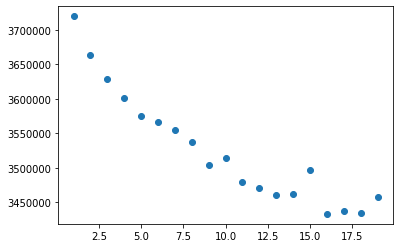

In [15]:
# 정확한 군집을 파악하기 위함
# 적당한 군집의 개수를 구하고 이를 적용
from sklearn.cluster import MiniBatchKMeans

wss=[]
for i in range(1,20):
    kmeans=MiniBatchKMeans(n_clusters=i)
    kmeans.fit(data_trans)
    wss.append(kmeans.inertia_)
    print(i)

np.shape(data_trans)
plt.scatter(range(1,20), wss)
plt.show()

In [16]:
K=7

kmeans=MiniBatchKMeans(n_clusters=K)
kmeans.fit(data_trans)
clusters3 = kmeans.labels_
(clusters3)

clusters=clusters3
K=7
unique, counts = np.unique(clusters, return_counts=True)
clusters , K , unique , counts

(array([6, 4, 4, ..., 6, 6, 4]),
 7,
 array([0, 1, 2, 3, 4, 5, 6]),
 array([ 5958, 10723, 10386, 11674, 12244, 10085,  8930], dtype=int64))

In [17]:
# 군집의 엔트로피를 구하는 방법
# 공식은 책 참조
# 모델을 튜닝하는데 참고용
n=data.shape[0]
H_C=0

for k in range(K): # k-th cluster
    n_k=counts[k]
    idx=np.where(clusters==k)
    n_category=0

    for j in range(data.shape[1]): # j-th attribute                
        x=data.iloc[idx[0], j]
        unique_x, counts_x = np.unique(x, return_counts=True)
        
        for m in range(len(counts_x)): # m-th category
            N_jk1=counts_x[m]
            H_C+=-(N_jk1/n_k * np.log(N_jk1/n_k)) * n_k / n
            n_category += 1        

N_jk1 , n_category
H_C

219.08869028521565

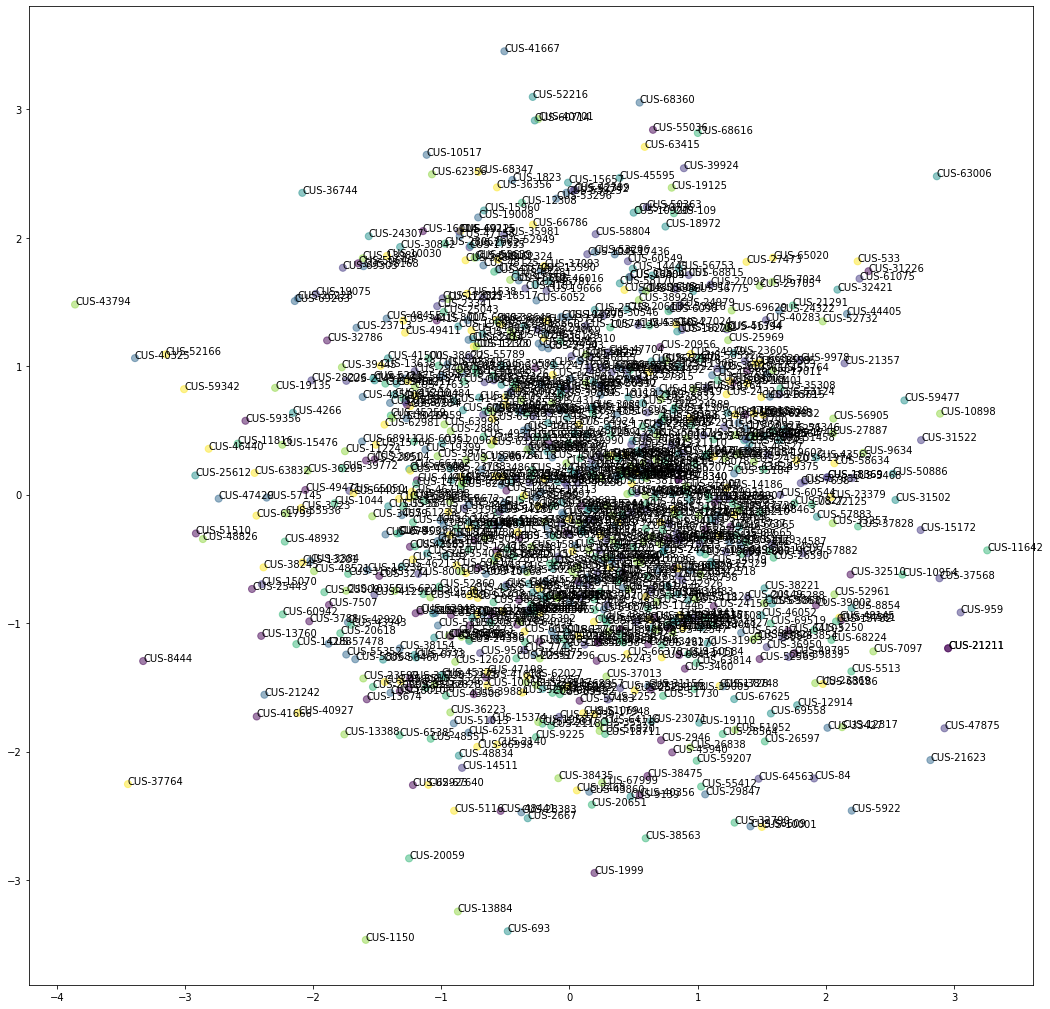

In [18]:
plt.figure(figsize=(18, 18)) 
area = 50
plt.scatter(result2[:, 0], result2[:, 1] , c=clusters[cho_idx]+1, s = area , alpha=0.5)
words = list(data.index[cho_idx])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.show()

In [19]:
clusters[cho_idx] ,  result2.shape

cus_names = list(data.index[cho_idx])
len(cus_names)

result3 = np.dot(result2 , result2.T)
result3

import pandas as pd 

df = pd.DataFrame(result3)
df.index = cus_names
df.columns = cus_names
df.to_csv("유사도_UBCF.csv")

In [32]:
df

,CUS-68815,CUS-53946,CUS-9371,CUS-5418,CUS-68342,CUS-68347,CUS-24118,CUS-48013,CUS-50563,CUS-33321,...,CUS-68239,CUS-66065,CUS-18369,CUS-67999,CUS-69603,CUS-67625,CUS-32990,CUS-36434,CUS-15070,CUS-46527
CUS-68815,3.788931,1.893015,0.585400,-0.543266,-2.761728,3.633782,-0.007707,-0.083132,-1.304531,-1.399832,...,1.616920,0.800346,2.103746,-3.595595,1.580869,-1.523093,0.680477,-1.831797,-3.428825,1.903622
CUS-53946,1.893015,1.240102,1.028154,0.383323,-1.042331,0.824632,-0.330423,0.058523,-0.912492,-0.311057,...,1.312088,1.096659,1.974500,-1.092748,0.058917,0.264613,0.233362,-0.834256,-2.675390,1.519828
CUS-9371,0.585400,1.028154,1.929340,1.552667,0.416857,-1.915337,-0.817488,0.237258,-0.853260,0.754373,...,1.510229,1.865351,2.633237,1.203365,-1.582733,2.328202,-0.161362,-0.080698,-2.935093,1.715745
CUS-5418,-0.543266,0.383323,1.552667,1.534459,1.146737,-2.725325,-0.725393,0.234509,-0.392967,1.064583,...,0.889919,1.435341,1.752644,2.080948,-1.852669,2.499902,-0.334749,0.442710,-1.649093,0.992295
CUS-68342,-2.761728,-1.042331,0.416857,1.146737,2.399966,-3.784801,-0.368840,0.175323,0.651909,1.465593,...,-0.600378,0.215596,-0.474572,3.427659,-1.990372,2.286131,-0.618245,1.427994,1.395859,-0.735397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUS-67625,-1.523093,0.264613,2.328202,2.499902,2.286131,-4.913480,-1.134866,0.382075,-0.384114,1.915854,...,1.107107,2.106297,2.372092,3.897374,-3.182403,4.185959,-0.645054,1.018399,-1.974832,1.216607
CUS-32990,0.680477,0.233362,-0.161362,-0.334749,-0.618245,1.011552,0.116916,-0.051176,-0.139842,-0.392074,...,0.107731,-0.108672,0.043314,-0.900658,0.548689,-0.645054,0.160833,-0.358304,-0.267217,0.135857
CUS-36434,-1.831797,-0.834256,-0.080698,0.442710,1.427994,-2.029287,-0.086085,0.067708,0.558986,0.783556,...,-0.643043,-0.195310,-0.763124,1.931843,-0.965296,1.018399,-0.358304,0.907860,1.393060,-0.763914
CUS-15070,-3.428825,-2.675390,-2.935093,-1.649093,1.395859,-0.048736,1.074716,-0.251911,2.032999,-0.002850,...,-3.111902,-3.002472,-4.923004,0.953176,0.959127,-1.974832,-0.267217,1.393060,6.249191,-3.582236
